In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tqdm
from transformers import GPT2Tokenizer

from Attention import *

In [2]:
# tok = AttentionUtils.load_tokens('tokens.csv')

# vocab_length = len(tok['to_token'])
# print(vocab_length)

In [3]:
# [tok['to_token']['<pad>'], tok['to_token']
#  ['<unk>'], tok['to_token']['<mask>']]


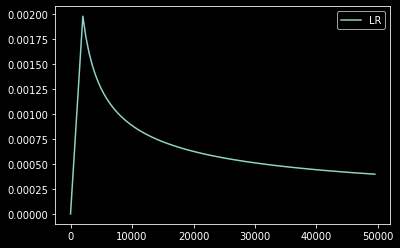

In [4]:
AttentionUtils.plot_schedule(128, 2000, 50000)

In [5]:
tf.keras.backend.clear_session()
tf.__version__

'2.5.0'

In [6]:
def build_token_contraint_loss(end_token):
    def start_end_loss(y_true, y_pred):
        end_tokens_pred = tf.reduce_sum(tf.cast(tf.math.equal(y_pred, end_token), tf.float32))
        return tf.square(end_tokens_pred - 1)
    return start_end_loss

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '<pad>'})
vocab_length = tokenizer.vocab_size

In [8]:
def tokenize(s, max_len=128):
    tok = tokenizer.encode(bytes.decode(s.numpy()),
                           max_length=max_len, padding='max_length')
    return tf.constant(tok, dtype=tf.int32)


def shift(x):
    return x[:, :-1], x[:, 1:]


In [9]:
sentences = tf.data.experimental.load(
    'sentences_combined_gpttokens.tfrecord', compression='GZIP')

BUFFER_SIZE = 10000
BATCH_SIZE = 64
batched_sentences = sentences.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
print(batched_sentences)


<PrefetchDataset shapes: (None, 2, 128), types: tf.int32>


In [10]:
for s in batched_sentences.take(1):
    print(s[:,0,:])
    break

tf.Tensor(
[[  264  1984    78 ... 50257 50257 50257]
 [27334   343    25 ... 50257 50257 50257]
 [  267  4598    25 ... 50257 50257 50257]
 ...
 [  357 24313   290 ... 50257 50257 50257]
 [  257  2588  4066 ... 50257 50257 50257]
 [  267  4598    25 ... 50257 50257 50257]], shape=(64, 128), dtype=int32)


In [11]:
# input_seq_len = 96
# output_seq_len = 96
d_model = 128

model = Transformer(num_layers=2, d_model=d_model, num_heads=8, dff=512,
     input_vocab_size=vocab_length+1, target_vocab_size=vocab_length+1, pe_input=1000, pe_target=1000)

# model = EncoderModel(num_layers=2, d_model=d_model, num_heads=8, dff=512,
#                         input_vocab_size=vocab_length+1, target_vocab_size=vocab_length, pe_input=1000, pe_target=1000)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

mask_token = tokenizer.pad_token_id

optimizer = AttentionUtils.scheduleAdam(d_model)
loss_function = AttentionUtils.mask_loss(
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none'), mask_token)

# add_loss = [[0.2, build_token_contraint_loss(tok['to_token']['<unk>'])]]

acc_function = AttentionUtils.get_masked_acc(mask_token)

In [12]:
checkpoint_path = "./checkpoints/Transformer2_GPT_Tokens/train"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [13]:
writer = tf.summary.create_file_writer('logs/transformer')
tf.summary.trace_on(graph=True, profiler=False)

In [14]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function()
def train_step(inp, tar):    
    with tf.GradientTape() as tape:
        tar_inp = tf.pad(tar[:, :-1], [[0, 0], [0, 1]], constant_values=mask_token)
        tar_real = tf.pad(tar[:, 1:], [[0, 0], [0, 1]], constant_values=mask_token)

        # tf.print(inp[0])
        # tf.print(tar_real[0])

        predictions, _ = model((inp, tar_inp), True)
        loss = loss_function(tar_real, predictions)

        # for l, f in add_loss:
        #     loss += f(tar_real, predictions) * l

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(acc_function(tar_real, predictions))


In [15]:
EPOCHS = 3
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    print(f"\nEPOCH {epoch+1}/{EPOCHS}:")
    pbar = tqdm.tqdm(batched_sentences)
    for data in pbar:
        inp, tar = data[:,0,:], data[:,1,:]
        # inp = tf.cast(inp, tf.int64)
        # tar = tf.cast(tar, tf.int64)
        
        train_step(inp, tar)
        pbar.set_description(f"loss: {train_loss.result():.5f}, accuracy: {train_accuracy.result():.5f}")
        ckpt_save_path = ckpt_manager.save()

    print(f"loss {train_loss.result()}\t accuracy {train_accuracy.result()} in {np.round(time.time()-start, 2)} seconds")
    



EPOCH 1/3:


loss: 4.94108, accuracy: 0.24903: 100%|█████████▉| 662/663 [08:43<00:00,  1.24it/s]

In [ ]:
class SentenceGenerator(tf.Module):
  def __init__(self, transformer, start_token, end_token, pad_token):
    self.transformer = transformer
    self.start_token = start_token
    self.end_token = end_token
    self.pad_token = pad_token

  def __call__(self, sentence, max_length=20, max_seq_length=127):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 1:
      sentence = sentence[tf.newaxis]

    encoder_input = sentence
    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=max_seq_length, dynamic_size=False)
    start_char = [t.numpy() for t in encoder_input[-1] if t != self.start_token][-1]
    output_array = output_array.write(0, tf.constant([start_char], dtype=tf.int64))

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      # print(encoder_input.shape, output.shape)
      predictions, _ = self.transformer(
          [encoder_input, output], training=False)

      # return tf.argmax(predictions, -1)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)
      # print(predicted_id)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id)

      # if predicted_id == self.end_token:
      #   break

    output = tf.transpose(output_array.stack())

    return output


In [ ]:
sent_gen = SentenceGenerator(
    model, start_token=mask_token, end_token=None, pad_token=None)


In [ ]:
for b_sent in batched_sentences.take(5):
  # print(b_sent[0])
  output = sent_gen(b_sent[0][0])
  # print(output.numpy())
  print("-"*75)
  print(f"Input Sequence: \n{tokenizer.decode(b_sent[0][0].numpy(), skip_special_tokens=True)}\n")
  print(
      f"Output Sequence: \n{tokenizer.decode(output.numpy()[0], skip_special_tokens=True)}\n")

  # print(attention_weights)


---------------------------------------------------------------------------
Input Sequence: 
 we're still working on it. sisko: well i guess the question is, how did they get aboard? or should i say, who placed them here? o'brien: i don't know who did it, but i know it definitely happened after we left the station. i ran a systems check before our departure. they weren't there then. sisko: which means someone aboard this ship is a saboteur. dax: we've got forty seven people on board. theoretically, anyone of them could've planted those devices. sisko: chief?

Output Sequence: 
?::......:...........!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

---------------------------------------------------------------------------
Input Sequence: 
 the gateway must be destroyed. agreed? sisko: agreed.[bridge] dax: let me get this straight. we're going to work with the jem'hadar to fight the jem'hadar. sisko: i don't relish this idea eithe